In [ ]:
# This is a series of examples using the icanswim/qchem quantum mechanic machine learning repo
# icanswim/qchem utilizes the icanswim/cosmosis data science machine learning repo

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS
from cosmosis.learning import Learn, Selector

from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import pyg_model, GraphNet

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader


RDKit WARNING: [16:43:52] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
#example exploring cosmosis/qchem QM9 dataset with rdkit data augmentation
ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atomic_number','aromatic',
                                                                   'degree','charge','coulomb',
                                                                   'homo','lumo'],
                                                             'embed': ['hybridization','chirality']},
                                             'criterion_input': {'target': ['U0']}},
                              'n': 10000,
                              'db': 'rdkit',
                              'n_conformers': 1,
                              'pad': False,
                              'pad_feats': ['mulliken','coulomb','aromatic','degree',
                                            'charge','n_hs','n_rads','atomic_number',
                                            'hybridization','chirality'],
                              'as_tensor': True,
                              'filter_on': ('n_atoms','<','18'),
                              'use_pickle': 'qm9_test.p',
                              'flatten': True}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

loading QM9 datadic from a pickled copy...
CDataset created...


{'model_input': {'X': tensor([ 6.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  4.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000, 36.8581, 10.5430, 10.8385, 10.8277,
          10.3116,  0.9040,  0.5000,  1.8064,  1.8046,  1.7186,  0.9040,  1.7572,
           0.5000,  1.8046,  1.7186,  0.9040,  1.7572,  1.8064,  0.5000,  1.7186,
           0.9040,  1.7572,  1.8064,  1.8046,  0.5000, -0.3877,  0.1171]),
  'embed': [array([5, 1, 1, 1, 1]), array([1, 1, 1, 1, 1])]},
 'criterion_input': {'target': tensor([-40.4789])}}

In [3]:
l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['model_input']['X'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]

longest molecule index:  5806  length:  782
shortest molecule index:  3  length:  23


{'model_input': {'X': tensor([ 8.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  2.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  7.3517e+01,  3.4509e+01,  3.4455e+01,
           1.0017e+00,  5.0000e-01,  4.3068e+00,  1.0017e+00,  4.3136e+00,
           5.0000e-01, -2.9280e-01,  6.8700e-02]),
  'embed': [array([5, 1, 1]), array([1, 1, 1])]},
 'criterion_input': {'target': tensor([-76.4047])}}

In [4]:
#example exploring cosmosis/qchem PyG dataset wrapper with Data object output
ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': True,
                              'pg_params': {'root': './data/'}}}

pgds = PGDS(**ds_params['train_params'])
print(pgds[55967])
print(pgds[1])

creating pytorch geometric QM9 dataset...
CDataset created...
Data(x=[29, 11], edge_index=[2, 56], edge_attr=[56, 4], y=[1, 19], pos=[29, 3], z=[29], name='gdb_57518', idx=[1])
Data(x=[4, 11], edge_index=[2, 6], edge_attr=[6, 4], y=[1, 19], pos=[4, 3], z=[4], name='gdb_2', idx=[1])


In [5]:
#example exploring cosmosis/qchem PyG dataset wrapper, padded with dictionary output
ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': False,
                              'pad': (29,11),
                              'pad_feats': ['x'],
                              'flatten': False,
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

pgds = PGDS(**ds_params['train_params'])
pgds[1]

creating pytorch geometric QM9 dataset...
CDataset created...


{'model_input': {'X': tensor([[0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 3.],
          [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0

loading QM9 datadic from a pickled copy...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:04.430860
epoch: 0, lr: 0.01
train loss: 355.46258544921875, val loss: 353.67779541015625
test loss: 25.27477264404297
learning time: 0:00:12.578683


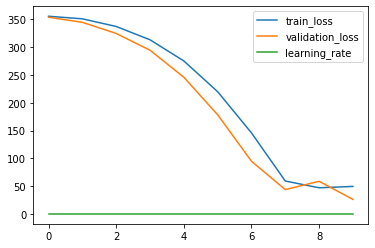

In [6]:
#example cosmosis/qchem QM9 dataset with filter, rdkit data augmentation, 
#embeddings and custom model 
rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['aromatic','degree',
                                                                   'charge','coulomb'],
                                                             'embed': ['hybridization','chirality']},
                                             'criterion_input': {'target': ['U0']}},
                              #'n': 10000, #non-random for testing
                              'db': 'rdkit',
                              'n_conformers': 1,
                              'pad': 29,
                              'pad_feats': ['mulliken','coulomb','aromatic','degree',
                                            'charge','n_hs','n_rads','atomic_number',
                                            'hybridization','chirality'],
                              'as_tensor': True,
                              'filter_on': ('n_atoms','>','10'), #filter out molecules with less than 10 atoms
                              'use_pickle': 'qm9_test.p',
                              'flatten': True}}


model_params = {'in_channels': 29+29+29+29*29+29*16+29*16, 
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel',
                'embed_params': [('hybridization',9,16,0,True),('chirality',5,16,0,True)]
               }
                
metrics_params = {'report_interval': 1,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 'subset': .2 #create random subset
                }

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=256, epochs=10)

creating pytorch geometric TUDataset dataset...
CDataset created...
GNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.692219
epoch: 0, lr: 0.01
train loss: 0.08219457184895873, val loss: 0.07378429919481277
sklearn train metric: 0.640625, sklearn validation metric: 0.75
learning time: 0:00:05.852874
epoch: 8, lr: 0.01
train loss: 0.06589256576262414, val loss: 0.06766947607199351
sklearn train metric: 0.78125, sklearn validation metric: 0.8333333333333334
test loss: 0.07413221274813016
learning time: 0:00:06.742559
sklearn test metric: 
0.6666666666666666 



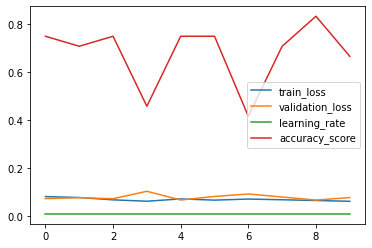

In [7]:
#example cosmosis/qchem PyG dataset wrapper with Data object output and
#sklearn metrics and custom model

model_params = {'in_channels': 7,
                'hidden': 64,
                'out_channels': 2}

ds_params = {'train_params': {'dataset': 'TUDataset',
                              'use_pyg': True,
                              'pg_params': {'root': './data/',
                                            'name': 'MUTAG'}}}

metrics_params = {'report_interval': 5,
                  'log_plot': False,
                  'sk_metric_name': 'accuracy_score',
                  'sk_params': {}}

opt_params = {'lr': 0.01}

crit_params = {}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=8, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:07.592251
epoch: 0, lr: 0.01
train loss: 486.08252044485397, val loss: 19.000786040958605
learning time: 0:00:23.012245
epoch: 2, lr: 0.01
train loss: 12.566032284114208, val loss: 12.25093748694972
learning time: 0:00:37.908948
epoch: 4, lr: 0.01
train loss: 11.682863128619367, val loss: 11.555228471755981
learning time: 0:00:52.411909
epoch: 6, lr: 0.01
train loss: 11.300363903953915, val loss: 11.7270121072468
learning time: 0:01:07.217293
epoch: 8, lr: 0.005
train loss: 11.142156916172231, val loss: 11.750299140026694
test loss: 10.248347131829513
learning time: 0:01:16.337558


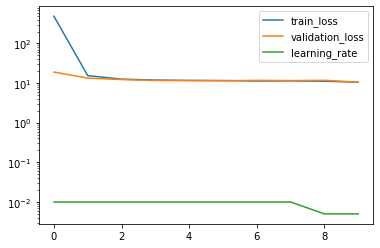

In [8]:
#example cosmosis/qchem PyG dataset wrapper with dictionary output and custom model
import numpy as np

class IndexTransform():
    #select index i from dataset with multiple target outputs
    def __init__(self, i):
        self.i = i
    def __call__(self, arr):
        return np.reshape(arr[self.i], (1,))

model_params = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': False,
                              'pad': (29,11),
                              'pad_feats': ['x'],
                              'flatten': True,
                              'target_transform': [IndexTransform(1)],
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=10)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.841332
epoch: 0, lr: 0.01
train loss: 1531.4390098170231, val loss: 1502.1861572265625
learning time: 0:00:08.382282
epoch: 10, lr: 0.01
train loss: 38.375208603708366, val loss: 33.9992036819458
test loss: 34.13811779022217
learning time: 0:00:15.496084


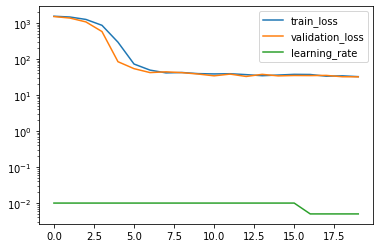

In [9]:
#example using cosmosis/qchem QM7 dataset and custom model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['ae']}},
                              'in_file': './data/qm7/qm7.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.860453
epoch: 0, lr: 0.01
train loss: 1558.6275699013158, val loss: 1531.7812194824219
learning time: 0:00:08.435068
epoch: 10, lr: 0.01
train loss: 49.764687186793275, val loss: 57.75001239776611
test loss: 47.783708572387695
learning time: 0:00:15.498870


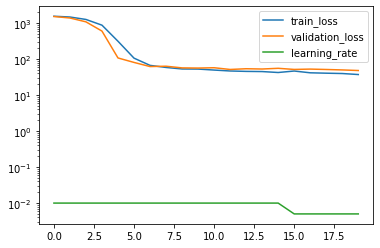

In [10]:
#example using the cosmosis/qchem QM7b dataset and custom model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['E']}},
                              'in_file': './data/qm7b/qm7b.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20)

In [13]:
#example exploring cosmosis/qchem QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atNUM']},
                                             'criterion_input': {'target': ['eAT']}},
                              'pad': None, #longest molecule = 23
                              'as_tensor': False,
                              'n': 1000, #non-random subset for testing
                              'selector': ['opt'],
                              'flatten': True}}

qm7x = QM7X(**ds_params['train_params'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['model_input']['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['model_input']['X'].shape) 
qm7x[m]


mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
longest molecule length:  20  index:  233
(20,)


{'model_input': {'X': array([6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.], dtype=float32)},
 'criterion_input': {'target': array([89.31958], dtype=float32)}}

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.828566
epoch: 0, lr: 0.01
train loss: 64.36433906555176, val loss: 61.311466217041016
test loss: 4.086267113685608
learning time: 0:00:07.955349


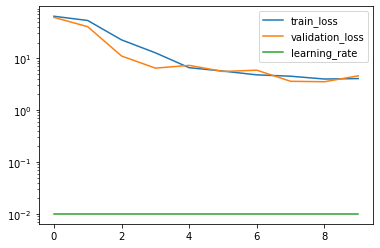

In [12]:
#example using the cosmosis/qchem QM7X dataset with filter and custom model
model_params = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['eAT']}},
                              'pad': 23,
                              'selector': ['opt'],
                              'flatten': True,
                              'n': 1000, #non-random subset for testing
                             }}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .2 #create randdom subset
                } 

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=64, epochs=10)

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:03.893527
epoch: 0, lr: 0.01
train loss: 556.1281522863052, val loss: 497.568115234375
learning time: 0:00:14.740650
epoch: 4, lr: 0.01
train loss: 36.083891588098865, val loss: 33.3883171081543
learning time: 0:00:25.569236
epoch: 8, lr: 0.01
train loss: 32.34799777760225, val loss: 18.7937437693278
test loss: 24.668277104695637
learning time: 0:00:28.843602


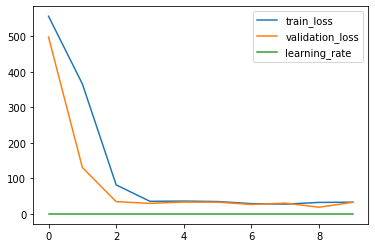

In [14]:
#example using cosmosis/qchem ANI1x dataset with filter and custom model
model_params = {'in_channels': 63*63, 
                'hidden': 8192, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['wb97x_dz.energy']}},
                              'pad_feats': ['coulomb'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=128, epochs=10)